In [76]:
import pandas as pd
from sqlalchemy import create_engine
import json
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [65]:
# Read the MySQL configuration from the JSON file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

In [66]:
# Extract MySQL connection details
mysql_config = config.get('mysql', {})
username = mysql_config.get('username', 'default_username')
password = mysql_config.get('password', 'default_password')
host = mysql_config.get('host', 'localhost')
database_name = mysql_config.get('database_name', 'your_database')

In [67]:
# Create the MySQL database connection string
db_url = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

# Create an SQLAlchemy engine
engine = create_engine(db_url)

# Use the engine to connect to the database
connection = engine.connect()

In [68]:
# Specify the SQL query to retrieve data from a table
query = "SELECT * FROM joined_rewa"

# Use Pandas to read data from the database into a DataFrame
df = pd.read_sql(query, connection)

# Close the database connection
connection.close()

In [69]:
# Calculate delta
df['delta'] = df['WindMeasured'] - df['WindForecast']
df

,LeftTableTime,RightTableTime,WindForecast,GustForecast,TempForecast,PrecipitationForecast,CloudForecast,WindDirForecast,WindDirBinForecast,WindMeasured,GustMeasured,TempMeasured,WindDirMeasured,BaroMeasured,Month,delta
0,2021-01-26 00:00:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,9.91,11.27,1.2,236.0,1027.5,1,-2.09
1,2021-01-26 00:10:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.69,12.63,1.2,234.0,1027.6,1,-1.31
2,2021-01-26 00:20:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,9.91,11.27,1.3,261.0,1027.5,1,-2.09
3,2021-01-26 00:30:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.11,11.86,1.1,242.0,1027.4,1,-1.89
4,2021-01-26 00:40:00,2021-01-26 02:00:00,12.0,16.0,2.0,0.0,100.0,287.0,W,10.89,11.86,1.1,244.0,1027.5,1,-1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127897,2023-10-02 21:10:00,2023-10-02 22:00:00,8.0,19.0,18.0,0.0,100.0,223.0,S,0.58,1.94,17.4,225.0,1012.6,10,-7.42
127898,2023-10-02 21:20:00,2023-10-02 22:00:00,8.0,19.0,18.0,0.0,100.0,223.0,S,0.58,1.94,17.4,182.0,1012.7,10,-7.42
127899,2023-10-02 21:30:00,2023-10-02 22:00:00,8.0,19.0,18.0,0.0,100.0,223.0,S,1.36,3.30,17.2,157.0,1012.6,10,-6.64
127900,2023-10-02 21:40:00,2023-10-02 22:00:00,8.0,19.0,18.0,0.0,100.0,223.0,S,1.94,3.89,17.1,183.0,1012.4,10,-6.06


In [50]:
# Assuming 'df' is your DataFrame with wind data
# You can define your bins and labels for wind speed
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,28,30,np.inf]  # Customize bin edges as needed
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24','24-26', '26-28', '28-30', '30+']

# Create a new column 'WindSpeedBin' with the binned wind speeds
df['WindMeasuredBin'] = pd.cut(df['WindMeasured'], bins=bins, labels=labels)
df['WindForecastBin'] = pd.cut(df['WindForecast'], bins=bins, labels=labels)

# Define wind direction bins
bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Bin wind directions and calculate mean wind speed for each bin
df['WindDirMeasuredBin'] = pd.cut(df['WindDirMeasured'], bins=bins, labels=labels)
#aggregated_data = df.groupby('WindDirBin')['WindSpeed'].count().reset_index()
aggregated_data_measured = df.groupby(['WindDirMeasuredBin', 'WindMeasuredBin']).agg({'WindMeasured':'mean', 'delta':'mean','WindDirMeasured':'count'}).reset_index()
aggregated_data_forecast = df.groupby(['WindDirBinForecast', 'WindForecastBin']).agg({'WindForecast':'mean', 'delta':'mean','WindDirForecast':'count'}).reset_index()

In [51]:
aggregated_data_measured['FrequencyMeasured'] = np.round(aggregated_data_measured['WindDirMeasured']/aggregated_data_measured['WindDirMeasured'].sum(),5)*100
aggregated_data_forecast['FrequencyForecast'] = np.round(aggregated_data_forecast['WindDirForecast']/aggregated_data_forecast['WindDirForecast'].sum(),5)*100

In [54]:
# Create a wind rose plot
fig = px.bar_polar(aggregated_data_measured, r='FrequencyMeasured', theta='WindDirMeasuredBin', color='WindMeasured',
                   template='plotly_dark', color_discrete_sequence=px.colors.sequential.Plasma_r)
# Set the figure size
fig.update_layout(width=1600, height=800)
fig.show()

In [55]:
# Create a wind rose plot
fig = px.bar_polar(aggregated_data_forecast, r='FrequencyForecast', theta='WindDirBinForecast', color='WindForecast',
                   template='plotly_dark', color_discrete_sequence=px.colors.sequential.Plasma_r)
# Set the figure size
fig.update_layout(width=1600, height=800)
fig.show()

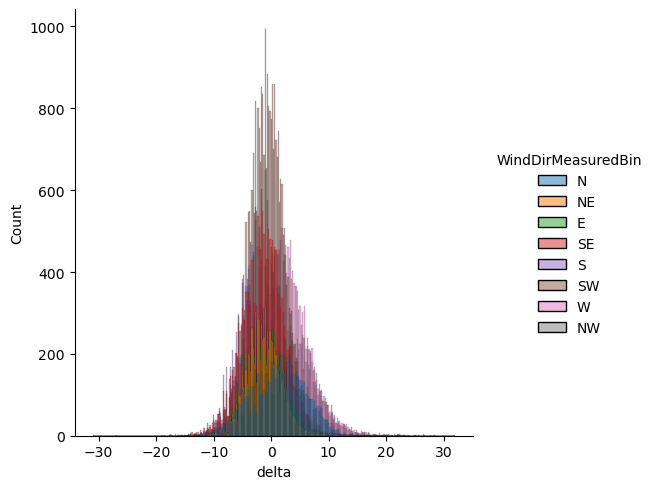

In [56]:
df['Month'].astype('category')
sns.displot(data=df, x='delta', hue='WindDirMeasuredBin', kind='hist')

In [74]:
df_avg = df.groupby('RightTableTime')[['WindMeasured', 'WindForecast', 'WindDirForecast', 'Month', 'CloudForecast','GustForecast','TempForecast','PrecipitationForecast']].mean().reset_index().dropna()
df_avg

,RightTableTime,WindMeasured,WindForecast,WindDirForecast,Month,CloudForecast,GustForecast,TempForecast,PrecipitationForecast
0,2021-01-26 02:00:00,10.594167,12.0,287.0,1.0,100.0,16.0,2.0,0.0
1,2021-01-26 04:00:00,11.809167,9.0,280.0,1.0,100.0,15.0,1.0,0.0
2,2021-01-26 06:00:00,11.273333,11.0,272.0,1.0,100.0,17.0,1.0,0.0
3,2021-01-26 08:00:00,9.377500,10.0,283.0,1.0,100.0,15.0,1.0,0.1
4,2021-01-26 10:00:00,9.540833,8.0,295.0,1.0,92.0,14.0,1.0,0.1
...,...,...,...,...,...,...,...,...,...
10693,2023-10-02 16:00:00,5.135833,7.0,234.0,10.0,100.0,15.0,19.0,0.0
10694,2023-10-02 18:00:00,3.483333,8.0,229.0,10.0,100.0,17.0,19.0,0.2
10695,2023-10-02 20:00:00,1.488333,8.0,232.0,10.0,100.0,18.0,18.0,0.0
10696,2023-10-02 22:00:00,1.536667,8.0,223.0,10.0,100.0,19.0,18.0,0.0


In [80]:
# Features and labels split
X = df_avg[['WindForecast', 'WindDirForecast', 'Month', 'CloudForecast','GustForecast','TempForecast','PrecipitationForecast']]
y = df_avg['WindMeasured']

# Train Valid Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Display feature importance
feature_importances = clf.feature_importances_

feature_importances = dict(zip(X.columns,feature_importances))
feature_importances

{'WindForecast': 0.6639891978343645,
 'WindDirForecast': 0.16944939459124392,
 'Month': 0.035443622782352066,
 'CloudForecast': 0.02270550073476974,
 'GustForecast': 0.04408897970973543,
 'TempForecast': 0.04874876962768056,
 'PrecipitationForecast': 0.015574534719853829}

In [82]:
# Predict on the validation set
y_pred = clf.predict(X_valid)

# Score 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Absolute Error: 2.16
Mean Squared Error: 8.61
R-squared (R2) Score: 0.78


In [83]:
y_pred

array([11.32322879,  6.98853333, 31.0486697 , ...,  7.51870833,
        8.67475   , 12.634525  ])

In [84]:
X_valid

,WindForecast,WindDirForecast,Month,CloudForecast,GustForecast,TempForecast,PrecipitationForecast
3324,11.0,154.0,10.0,100.0,25.0,12.0,0.0
5376,9.0,66.0,4.0,82.0,14.0,5.0,0.0
4655,24.0,292.0,2.0,100.0,37.0,4.0,0.0
1585,6.0,10.0,6.0,0.0,7.0,16.0,0.0
6370,12.0,329.0,7.0,6.0,11.0,23.0,0.0
...,...,...,...,...,...,...,...
324,4.0,219.0,2.0,0.0,5.0,3.0,0.0
10055,8.0,233.0,7.0,100.0,15.0,14.0,0.0
1118,9.0,120.0,4.0,100.0,16.0,6.0,0.0
9419,11.0,250.0,4.0,6.0,21.0,4.0,0.0


In [85]:
y_valid

3324      9.930000
5376      9.735833
4655     27.585833
1585     10.025833
6370     13.395000
           ...    
324       5.280833
10055     5.248333
1118      6.901667
9419      6.400000
10394    10.528333
Name: WindMeasured, Length: 2113, dtype: float64